In [3]:
import torch
import numpy as np
from lib.dataset import NIDSDataset

# We define this function to make the solution easier
def bytes_to_int(bytes_array):
    """
    Calculate the integer value that is represented by the provided array of bytes.
    Example: Input is [8, 0], which represents the hexadecimal 0x0800 number. This function will then calculate
    8 * 16^2 + 0 * 16^1 = 2048

    :param bytes_array: Array/list of bytes
    :type bytes_array: ``list`` of ``int``
    :return: The integer value represented by the array of bytes.
    :rtype: ``int``
    """
    n_bytes = len(bytes_array)

    value = 0

    for i in range(n_bytes):
        value += (pow(256, n_bytes - i - 1) * bytes_array[i])

    return value

# Initialize the dataset
dset = NIDSDataset(
    packets_file="./data/dataset_packets_v2.npy", 
    labels_file="./data/dataset_labels_v1.npy")

# The input_buffer contains all input features
input_buffer = []
label_buffer = []

# Iterate over the dataset, and add all valid input features to the buffer
# Accordingly, also extract the label for each of those packets and save it as well

for packet in dset:
    label = packet.get_label()
    input_sample = np.zeros(64)
    
    # For each valid packet, extract the features to the input_sample and append the input_sample to the 
    # input_buffer. Do not forget the labels!
    # Your code starts here
    
    counter = 0
    for word in packet:
        
        if counter == 64:
            input_buffer.append(input_sample)
            label_buffer.append(label)
            break
        elif counter == 20:
                protocol = bytes_to_int(word[3:])
                
                # If the transport protocol is not TCP or UDP, skip
                if not ((protocol == 6) or (protocol == 17)):
                    break
        elif counter == 12:
            ethertype = bytes_to_int(word[:2])
            
            # If the packet is not an IPv4 packet, we skip it
            if ethertype != 0x0800:
                break
        
        # Use word.shape[0] to account for word sizes smaller than for in the case of packets smaller than 64 bytes.
        input_sample[counter:counter + word.shape[0]] = word
        
        if word.shape[0] < 4:
            # We reached the end of the packet: Store it
            input_buffer.append(input_sample)
            label_buffer.append(label)
            break
        
        counter += 4
    
print("We extracted {} input samples.".format(len(input_buffer)))

We extracted 1200 input samples.


For use in PyTorch, we need to present the input samples as *tensors*. Additionally, the input dimensionality needs to be slightly changed to be suitable for inference.

In [4]:
input_tensors = []

for input_sample in input_buffer:
    # Turn the Numpy array into a PyTorch tensor
    input_tensor = torch.from_numpy(input_sample)
    # Change input dimensionality
    input_tensor = input_tensor.view(1, 1, 64)
    
    input_tensors.append(input_tensor)

### Inference

Once we have extracted a set of input samples from the dataset, we can do inference on the neural network. For this excercise, we use a Convolutional Neural Network (CNN) with 1D convolutions that takes an input of size 64.

As the network has already been trained, we only need to load it from the storage:

In [5]:

from lib.nn_model import ExampleCNN1D1x64

model = ExampleCNN1D1x64(13)

# Load the trained parameters
model.load_state_dict(torch.load("./data/cnn1d1x64.model"))

# Set the Batch Normalization layers for inference
model.eval()

ExampleCNN1D1x64(
  (layer1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.95, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.95, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer3): Sequential(
    (0): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.95, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer4): Sequential(
    (0): Conv1d(64, 96, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(96

The output of the above cell gives an overview of the used neural network. Finally, 

In [6]:
import matplotlib.pyplot as plt

predictions = []

for input_tensor in input_tensors:
    output_tensor = model(input_tensor.float())
    
    _, predicted = torch.max(output_tensor, 1)
    predictions.append(predicted)

predictions = torch.stack(predictions, 0).numpy()

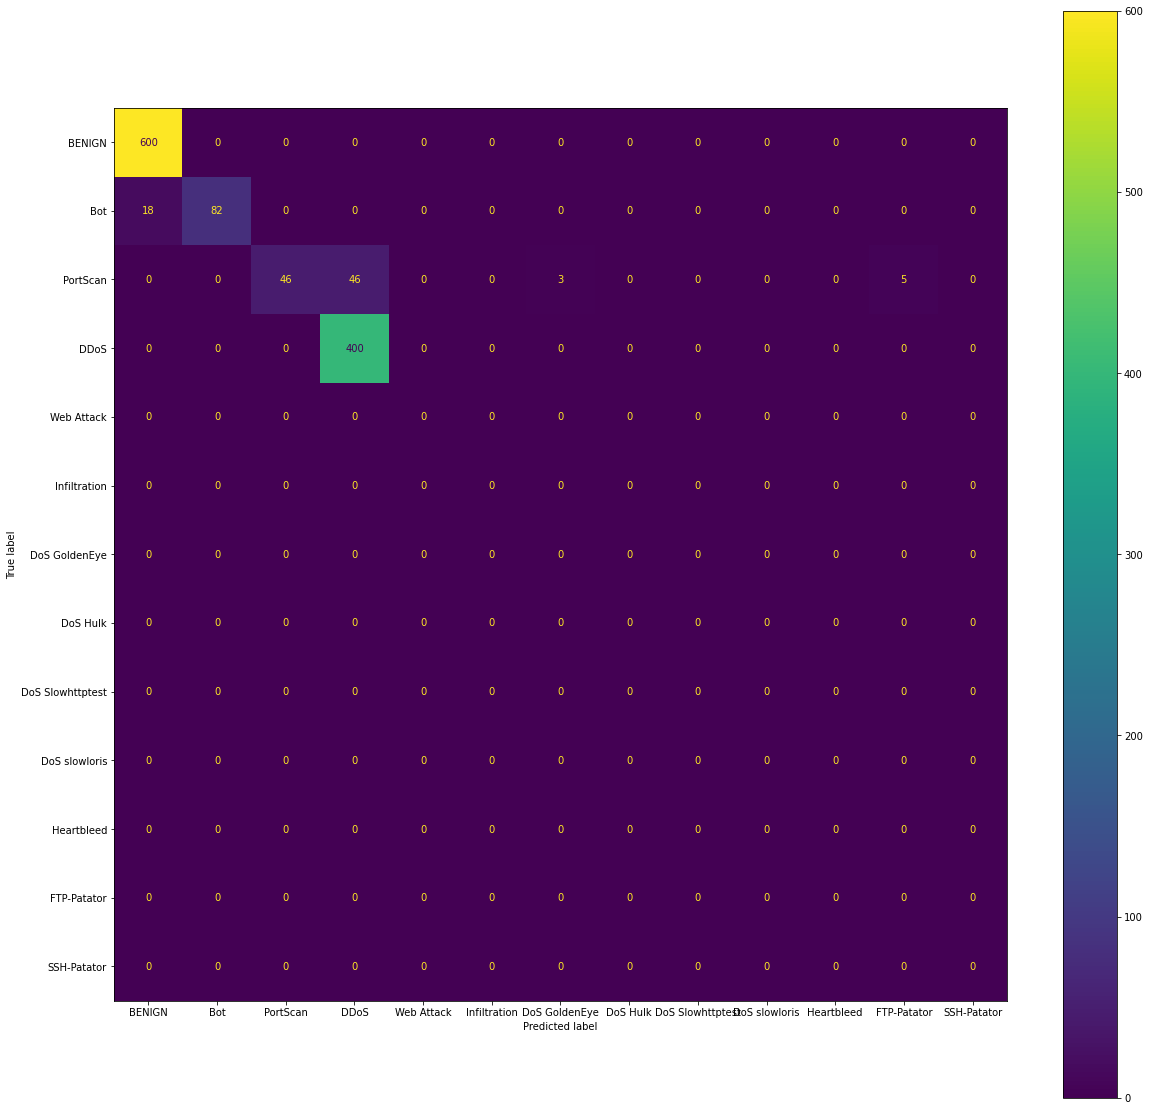

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from lib.nn_model import label_mapping

# Transform the indices to their corresponding class label:
labelled_predictions = []
for prediction in predictions:
    labelled_predictions.append(label_mapping[prediction[0]])

# Choose output figure size
_, ax = plt.subplots(figsize=(20, 20))

# Calculate the confusion matrix
cm = confusion_matrix(label_buffer, labelled_predictions, labels=label_mapping)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_mapping)
disp.plot(ax=ax)
plt.show()

In [8]:
from sklearn.metrics import classification_report

print(classification_report(label_buffer, labelled_predictions, 
                            labels=label_mapping, 
                            target_names=label_mapping,
                            digits=4,
                            zero_division=0
                           ))

                  precision    recall  f1-score   support

          BENIGN     0.9709    1.0000    0.9852       600
             Bot     1.0000    0.8200    0.9011       100
        PortScan     1.0000    0.4600    0.6301       100
            DDoS     0.8969    1.0000    0.9456       400
      Web Attack     0.0000    0.0000    0.0000         0
    Infiltration     0.0000    0.0000    0.0000         0
   DoS GoldenEye     0.0000    0.0000    0.0000         0
        DoS Hulk     0.0000    0.0000    0.0000         0
DoS Slowhttptest     0.0000    0.0000    0.0000         0
   DoS slowloris     0.0000    0.0000    0.0000         0
      Heartbleed     0.0000    0.0000    0.0000         0
     FTP-Patator     0.0000    0.0000    0.0000         0
     SSH-Patator     0.0000    0.0000    0.0000         0

       micro avg     0.9400    0.9400    0.9400      1200
       macro avg     0.2975    0.2523    0.2663      1200
    weighted avg     0.9511    0.9400    0.9354      1200

